Notebook where we perform the spatial similarity analysis between task-based patterns both at the group and subject level

In [1]:
from nilearn.image import load_img
import tqdm

from nilearn import image

from nilearn.masking import apply_mask, unmask
from scipy.spatial.distance import squareform
import bct
from scipy.stats import norm
from statsmodels.stats.multitest import  multipletests
from scipy.stats import ttest_1samp
from scipy.spatial.distance import dice

plt.rcParams['font.family'] = ['arial']

In [2]:
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
n_subjects = len(final_subjects)

# Similarities at group-level

In [3]:
edge_stroop = load_img("../results/second-level/edge_gsr/shen/task-stroop/Incongruent-Congruent/stat.nii.gz")
edge_stroop = squareform(np.squeeze(edge_stroop.get_fdata()), checks=False)

edge_msit = load_img("../results/second-level/edge_gsr/shen/task-msit/Incongruent-Congruent/stat.nii.gz")
edge_msit = squareform(np.squeeze(edge_msit.get_fdata()), checks=False)

r, _ = stats.spearmanr(edge_stroop, edge_msit)

print("EDGE T-similarity: ", r)

node_stroop = load_img("../results/second-level/node_gsr_shen/task-stroop/Incongruent-Congruent/stat.nii.gz")
node_stroop = np.squeeze(node_stroop.get_fdata())

node_msit = load_img("../results/second-level/node_gsr_shen/task-msit/Incongruent-Congruent/stat.nii.gz")
node_msit = np.squeeze(node_msit.get_fdata())

r, _ = stats.spearmanr(node_stroop, node_msit)

print("NODE T-similarity: ", r)

EDGE T-similarity:  0.6496246548062633
NODE T-similarity:  0.8731153139527708


In [5]:
pattern = "../results/first-level/node_gsr_roi/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = "../results/first-level/node_gsr_roi/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_node_ef = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = "../results/first-level/edge_gsr/shen/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_edge_ef = []
for subj in final_subjects:
    stroop_edge_data = image.load_img(pattern % subj).get_fdata()
    stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
    stroop_edge_ef.append(stroop_edge_data)
stroop_edge_ef = np.array(stroop_edge_ef)

pattern = "../results/first-level/edge_gsr/shen/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_edge_ef = []
for subj in final_subjects:
    msit_edge_data = image.load_img(pattern % subj).get_fdata()
    msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
    msit_edge_ef.append(msit_edge_data)
    
msit_edge_ef = np.array(msit_edge_ef)

In [6]:
print(stroop_node_ef.shape, "", msit_node_ef.shape)
print(stroop_edge_ef.shape, "", msit_edge_ef.shape)

(242, 268)  (242, 268)
(242, 35778)  (242, 35778)


In [7]:
t_node_stroop, p_node_stroop = np.apply_along_axis(ttest_1samp, axis=0, arr=stroop_node_ef, popmean=0)
t_node_msit, p_node_msit = np.apply_along_axis(ttest_1samp, axis=0, arr=msit_node_ef, popmean=0)

t_edge_stroop, p_edge_stroop = np.apply_along_axis(ttest_1samp, axis=0, arr=stroop_edge_ef, popmean=0)
t_edge_msit, p_edge_msit = np.apply_along_axis(ttest_1samp, axis=0, arr=msit_edge_ef, popmean=0)

In [8]:
print(stats.spearmanr(t_node_stroop, t_node_msit))
print(stats.spearmanr(t_edge_stroop, t_edge_msit))

n_rois = len(p_node_stroop)
thr = 0.05/n_rois

print(1-dice(p_node_stroop<thr, p_node_msit<thr))
print(1-dice(p_edge_stroop<thr, p_edge_msit<thr))

n_links = len(p_edge_stroop)
thr = 0.05/n_links

print(1-dice(p_node_stroop<thr, p_node_msit<thr))
print(1-dice(p_edge_stroop<thr, p_edge_msit<thr))

SpearmanrResult(correlation=0.8734195444397824, pvalue=4.193649281839168e-85)
SpearmanrResult(correlation=0.6496246548062633, pvalue=0.0)
0.8587570621468926
0.4315715785789289
0.822742474916388
0.4262152777777778


Check that same similarity rates are obtained when sub-sampling the number of links to the same number of regions (268)

In [11]:
rng = np.random.RandomState(0)
n_boots = 10000
n_links = len(p_edge_stroop)
n_rois = len(p_node_stroop) 
sampled_link_corrs = np.zeros(n_boots)
for ii in tqdm.tqdm_notebook(range(n_boots)):
    idxs_boot = rng.choice(np.arange(n_links), size=n_rois, replace=False)
    sampled_link_corrs[ii] = stats.spearmanr(t_edge_stroop[idxs_boot],
                                       t_edge_msit[idxs_boot])[0]

<IPython.core.display.Javascript object>

<ipython-input-11-ad50b5d28194>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii in tqdm.tqdm_notebook(range(n_boots)):


  0%|          | 0/10000 [00:00<?, ?it/s]

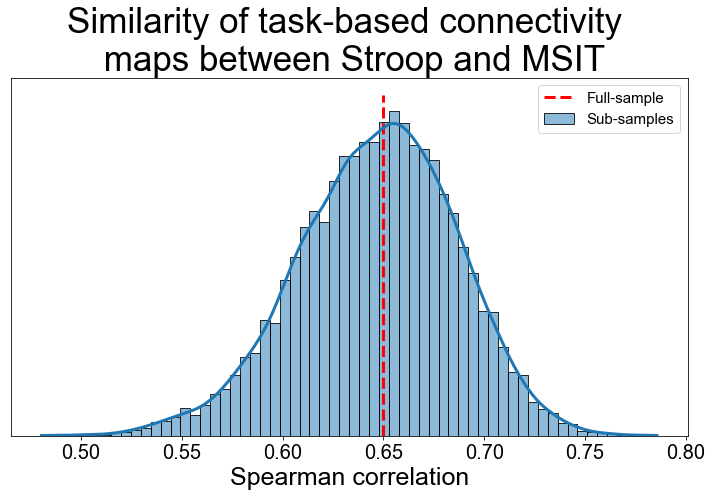

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(sampled_link_corrs, kde=True, ax=ax, alpha=0.5, line_kws={'linewidth':3}, 
             label="Sub-samples")
ax.vlines(x = stats.spearmanr(t_edge_stroop,t_edge_msit)[0], 
           ymin=0, ymax=ax.get_ylim()[1], color='red', linestyle='dashed', label='Full-sample', linewidth=3)
ax.tick_params(labelsize=20)
ax.set_yticks([])
ax.set_yticklabels("", size=0)
ax.set_ylabel("")
ax.set_xlabel("Spearman correlation", size=25)
ax.set_title("Similarity of task-based connectivity \n maps between Stroop and MSIT", 
             size=35)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("../figures/Fig_supp_sim_edge_subsampling.png")
plt.savefig("../figures/Fig_supp_sim_edge_subsampling.svg")
plt.savefig("../figures/Fig_supp_sim_edge_subsampling.pdf")

In [17]:
print(stats.spearmanr(t_edge_stroop,t_edge_msit)[0])
print(np.round(np.mean(sampled_link_corrs), 2))
print(np.round(np.std(sampled_link_corrs), 2))

0.6496246548062633
0.65
0.04


## GROUP-LEVEL

In [10]:
# Spearman similarity between tasks varying the number of subjects

from scipy.stats import spearmanr

rng = np.random.RandomState(0)
n_shuffles = 10
n_points = 10
thresholds = [1e-6, 1e-4, 1e-2]
n_thr = len(thresholds)

or_node, or_edge = np.zeros(shape=(n_thr, n_points, n_shuffles)), np.zeros(shape=(n_thr, n_points, n_shuffles))
cors_node, cors_edge = np.zeros(shape=(n_points, n_shuffles)), np.zeros(shape=(n_points, n_shuffles))

for ii, prop in tqdm.tqdm(enumerate(np.linspace(0.1, 1, 10))):
    for jj, shuffle in enumerate(range(n_shuffles)):
        idxs_shuffle = rng.choice(np.arange(n_subjects), size=n_subjects, replace=False)
        idxs_sub = idxs_shuffle[:int(prop*n_subjects)]

        t_node_stroop, p_node_stroop = np.apply_along_axis(ttest_1samp, 
                                                           axis=0, 
                                                           arr=stroop_node_ef[idxs_sub,:], 
                                                           popmean=0)
        
        t_node_msit, p_node_msit = np.apply_along_axis(ttest_1samp,
                                                       axis=0, 
                                                       arr=msit_node_ef[idxs_sub,:], 
                                                       popmean=0)

        t_edge_stroop, p_edge_stroop = np.apply_along_axis(ttest_1samp, 
                                                           axis=0, 
                                                           arr=stroop_edge_ef[idxs_sub,:], 
                                                           popmean=0)
        
        t_edge_msit, p_edge_msit = np.apply_along_axis(ttest_1samp, 
                                                       axis=0, 
                                                       arr=msit_edge_ef[idxs_sub,:], 
                                                       popmean=0)

        # Correlations
        cors_node[ii,jj] = spearmanr(t_node_stroop, t_node_msit)[0]
        cors_edge[ii,jj] = spearmanr(t_edge_stroop, t_edge_msit)[0]
        
        for kk, alpha in enumerate(thresholds):
            or_node[kk,ii,jj] = 1-dice(p_node_stroop<alpha, p_node_msit<alpha)
            or_edge[kk,ii,jj] = 1-dice(p_edge_stroop<alpha, p_edge_msit<alpha)

10it [14:59, 89.90s/it]


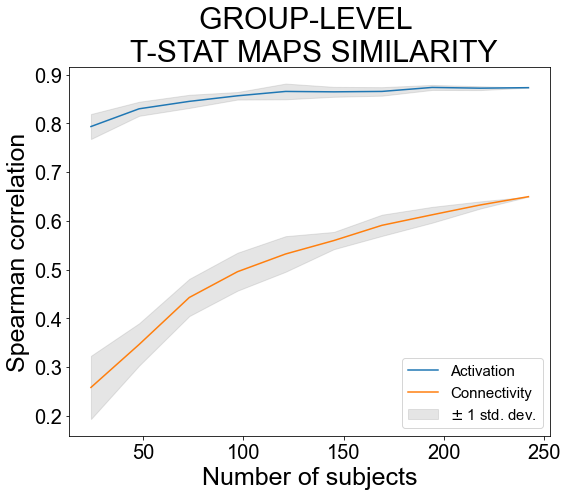

In [28]:
xticks = np.round(np.linspace(0.1, 1, 10)*n_subjects)

fig, ax = plt.subplots(figsize=(8,7))

mean_ = np.mean(cors_node, axis=1)
std_ = np.std(cors_node, axis=1)

ax.plot(xticks, mean_, label = "Activation")

ax.fill_between(xticks, mean_ + std_,  mean_ - std_, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

mean_ = np.mean(cors_edge, axis=1)
std_ = np.std(cors_edge, axis=1)

ax.plot(xticks, mean_, label = "Connectivity")
ax.fill_between(xticks, mean_ + std_,  mean_ - std_, color='grey', alpha=.2)
ax.legend()
ax.set_ylabel("Spearman correlation", size=25)
ax.set_xlabel("Number of subjects", size=25)
ax.set_title("GROUP-LEVEL \n T-STAT MAPS SIMILARITY", size=30)
ax.legend(fontsize=15)
ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("../plots/similarity_analysis_roi.png", dpi=300)
plt.savefig("../plots/similarity_analysis_roi.svg", dpi=300)
plt.savefig("../plots/similarity_analysis_roi.pdf", dpi=300)

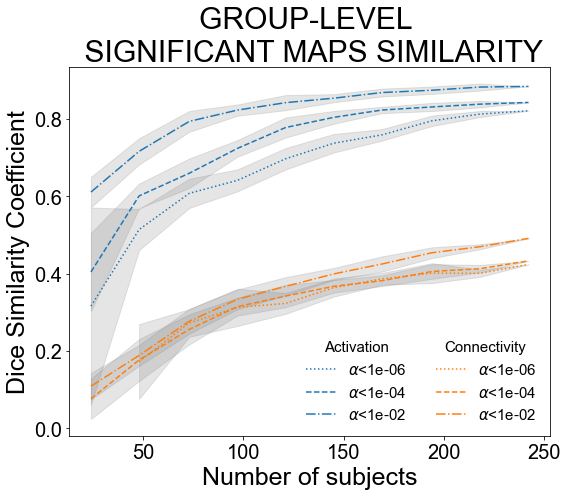

In [23]:
# Overlapping analysis between tasks using the DICE coefficient, varying the number of subjects and thresholds
xticks = np.round(np.linspace(0.1, 1, 10)*n_subjects)

fig, ax = plt.subplots(figsize=(8, 7))

mean_ = np.mean(or_node, axis=2)
std_ = np.std(or_node, axis=2)

for (kk, alpha), lstyle  in zip(enumerate(thresholds), ['dotted', 'dashed', 'dashdot']):
    ax.plot(xticks, mean_[kk,:], label = "" + r"$\alpha$" + "<%.0e" % alpha, 
                c="C0", linestyle=lstyle)
    ax.fill_between(xticks, mean_[kk,:] + std_[kk,:],  mean_[kk,:] - std_[kk,:], color='grey', 
                        alpha=.2)

mean_ = np.mean(or_edge, axis=2)
std_ = np.std(or_edge, axis=2)

for (kk, alpha), lstyle in zip(enumerate(thresholds), ['dotted', 'dashed', 'dashdot']):
    ax.plot(xticks, mean_[kk,:], label = "" + r"$\alpha$" + "<%.0e" % alpha,
                c="C1", linestyle=lstyle)
    ax.fill_between(xticks, mean_[kk,:] + std_[kk,:],  mean_[kk,:] - std_[kk,:], color='grey', 
                        alpha=.2)

ax.legend(fontsize=15, ncol=2, frameon=False)
ax.set_ylabel("Dice Similarity Coefficient", size=25)
ax.set_xlabel("Number of subjects", size=25)
ax.set_title("GROUP-LEVEL \n SIGNIFICANT MAPS SIMILARITY", size=30)

ax.text(x=140, y=0.2, s="Activation", size=15)
ax.text(x=200, y=0.2, s="Connectivity", size=15)

ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig("../plots/overlapping_analysis_roi.png", dpi=300)
plt.savefig("../plots/overlapping_analysis_roi.svg", dpi=300)
plt.savefig("../plots/overlapping_analysis_roi.pdf", dpi=300)

## SUBJECT LEVEL

In [4]:
pattern = "../results/first-level/node_gsr_roi/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_node_stat = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = "../results/first-level/node_gsr_roi/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_node_stat = np.array([np.squeeze(image.load_img(pattern % subj).get_fdata()) \
                           for subj in final_subjects])

pattern = "../results/first-level/edge_gsr/shen/task-stroop/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
stroop_edge_stat = []
for subj in final_subjects:
    stroop_edge_data = image.load_img(pattern % subj).get_fdata()
    stroop_edge_data = squareform(np.squeeze(stroop_edge_data), checks=False)
    stroop_edge_stat.append(stroop_edge_data)
stroop_edge_stat = np.array(stroop_edge_stat)

pattern = "../results/first-level/edge_gsr/shen/task-msit/sub-%d/Incongruent-Congruent/effect_size.nii.gz"
msit_edge_msit = []
for subj in final_subjects:
    msit_edge_data = image.load_img(pattern % subj).get_fdata()
    msit_edge_data = squareform(np.squeeze(msit_edge_data), checks=False)
    msit_edge_msit.append(msit_edge_data)
    
msit_edge_msit = np.array(msit_edge_msit)

In [5]:
from scipy.stats import spearmanr
sims_node = [spearmanr(a,b)[0] for a, b in zip(stroop_node_stat, msit_node_stat)]
sims_edge = [spearmanr(a,b)[0] for a, b in zip(stroop_edge_stat, msit_edge_msit)]

In [6]:
from scipy.stats import ttest_rel
ttest_rel(sims_node, sims_edge)

Ttest_relResult(statistic=23.751998825467847, pvalue=4.585392771306681e-65)

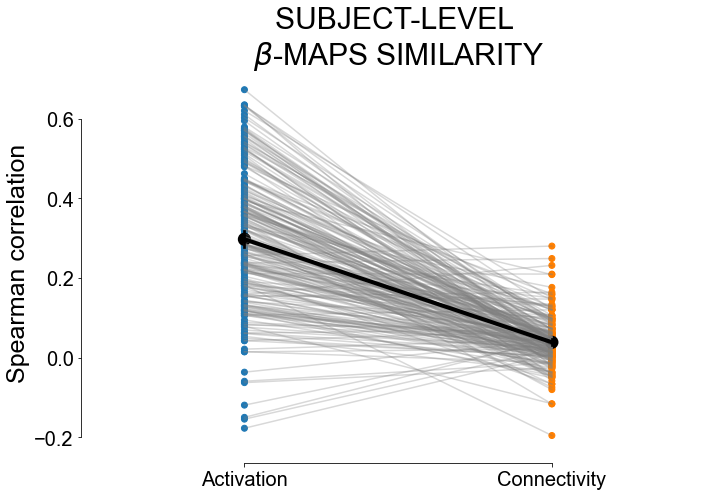

In [34]:
fig, ax= plt.subplots(figsize=(10,7))

for x,y in zip(sims_node, sims_edge):
    ax.scatter([0,1], [x, y], c=[sns.color_palette("Paired")[1], 
                                  sns.color_palette("Paired")[7]])
    if x>y:
        c="grey"   
    else:
        c="grey"
        
    ax.plot([0,1], [x, y], color=c, alpha=0.3)
    
sns.pointplot(x="variable", y="value", 
              scale=1.5,
              data=pd.melt(pd.DataFrame({'node':sims_node, 'edge':sims_edge})), color='black',
              ax=ax)
ax.set_ylabel("Spearman correlation", size=25)
ax.set_xticklabels(["Activation", "Connectivity"], size=20)
ax.set_xlabel("")
ax.tick_params(labelsize=20)
ax.set_title("SUBJECT-LEVEL \n" + r"$\beta$-MAPS SIMILARITY", size=30)
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.savefig("../plots/subject_level_betas_similarity_analysis_roi.png", dpi=300)
plt.savefig("../plots/subject_level_betas_similarity_analysis_roi.svg", dpi=300)
plt.savefig("../plots/subject_level_betas_similarity_analysis_roi.pdf", dpi=300)

In [24]:
import dabest
dabest.load(pd.DataFrame({'activation': sims_node, 'connectivity': sims_edge, 'id':np.arange(len(sims_edge))}), 
            idx = ("activation", "connectivity"), id_col='id', paired=True).cohens_d.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_permutation,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,activation,connectivity,242,242,Cohen's d,True,-2.073606,95,-2.302218,-1.814964,0.0,5.608138e-39,465.0,4.585393e-65,23.751999


In [28]:
dabest.effsize.cohens_d(control=sims_edge, test=sims_node, is_paired=True)

2.073605951654456